In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from datetime import datetime, timedelta
from scipy import stats
import statsmodels.api as sm
plt.style.use("seaborn-v0_8")

import warnings
warnings.filterwarnings('ignore')

## Step 1

#### Extend the PCA monitoring framework in lesson 4.3 with the goal of obtaining a systemic risk indicator combining signals of correlation breakdown and of widening credit spread


The computational framework adopted in lesson $\S \, 4.3$ made use of nine ETFs of the SPDR series, issued by State Street to target specific industry and service sectors in the economy, with each ETF composed exclusively of stocks that are within the S&P500 index.
The computations start from January 2007 and extend until the present date. 
That is why only the nine ETFs already existing in 2007, out of the full suite of eleven SPDR ETFs, were used in the analysis.

Beyond the SPDR ETFs, extra tickers were tracked to follow the volatility of the markets (^VIX), the 10-year Treasury bonds yields (^TNX), and an ETF from iShares reproducing the yield of investment grade corporate bonds (LQD).

All of the data series above are taken with a daily frequency at markets closing time.

Further, we gather daily yield series from the FRED database, for Baa investment grade $\geq 20$-year corporate bonds as graded by Moody's (BAA) and again the 10-year Treasury bond yields (DGS10).

To summarise:

| Ticker | Description |
|:------:|:------------|
| | **SPDR ETFs**
| `XLB`  | S&P500 Materials stocks |
| `XLE`  | S&P500 Energy stocks |
| `XLF`  | S&P500 Financial stocks |
| `XLI`  | S&P500 Industrial stocks |
| `XLK`  | S&P500 Technology stocks |
| `XLP`  | S&P500 Consumer Staples stocks |
| `XLU`  | S&P500 Utilities stocks |
| `XLV`  | S&P500 Healthcare stocks |
| `XLY`  | S&P500 Consumer Discretionary stocks |
| |**Other market data**
| `^VIX` | Market volatility index |
| `^TNX` | 10-year Treasury yields index|
| `LQD`  | Liquid, investment-grade corporate bond yields |
|  |**FRED data**
| `BAA`  | Moody's Baa-rated corporate bond yields |
| `DGS10`| 10-year Treasury yields |


Below, the shape of the `pandas` DataFrame for the 9 SPDR ETFs downloaded, sporting for dimensions the number of daily observations for the period 2007-2025 (after data cleaning) $\times$ the 9 ETFs.

In [2]:
# 11 Sector ETFs + VIX & 10‑yr yield for validation
sector_tickers = [
    "XLK", "XLF", "XLV", "XLE", "XLI", "XLY",
    "XLP", "XLB", "XLU"#, "^GSPC"
]
extra_tickers = ["^VIX", "^TNX", "LQD"] #"SP500BDT"]    # VIX and 10‑yr Treasury yield

start = "2007-01-04"
end = datetime.today() - timedelta(days=1)
end = end.strftime("%Y-%m-%d")
raw = pd.DataFrame(
    yf.download(sector_tickers + extra_tickers, start=start, end=end, progress=False, auto_adjust=True)
)["Close"]

# Drop rows with all‑NaNs (market holidays)
prices = raw.dropna(how="all")

# 1. Daily log‑returns
rets = pd.DataFrame(np.log(prices / prices.shift(1))).dropna()

# 2. Winsorise 4‑sigma tails (simple clip)
sigma4 = 4 * rets.std()
rets = rets.clip(lower=-sigma4, upper=sigma4, axis=1)

# 3. Selecting the sector returns
sector_rets = rets[sector_tickers]         # 9 × T matrix

print("Shape of downloaded market data of SPDR ETFs: ", sector_rets.shape)

Shape of downloaded market data of SPDR ETFs:  (4686, 9)


We see that the number of observations for the remaining data series extracted from markets agrees with the previous database at 4684 datapoints:

In [3]:
print("Shape of downloaded market data of volatility and fixed income indices: ", rets[["^VIX", "^TNX", "LQD"]].shape)

Shape of downloaded market data of volatility and fixed income indices:  (4686, 3)


FRED series `BAA`, although nominally taken with daily frequency as declared on the FRED website, in reality exhibits monthly frequency when extracted from the database.

In [4]:
fred = Fred(api_key="94fd20817a25e8215aa058f93235ba89")

fred.get_series_info("BAA")

id                                                                         BAA
realtime_start                                                      2025-08-21
realtime_end                                                        2025-08-21
title                                Moody's Seasoned Baa Corporate Bond Yield
observation_start                                                   1919-01-01
observation_end                                                     2025-07-01
frequency                                                              Monthly
frequency_short                                                              M
units                                                                  Percent
units_short                                                                  %
seasonal_adjustment                                    Not Seasonally Adjusted
seasonal_adjustment_short                                                  NSA
last_updated                                        

A workaround is found in downloading FRED's `DBAA` series instead, with the initial letter D evidently standing for *daily*.

Given that the Treasury yields data `DGS10` have more observations than all other series downloaded, in fact spanning over days when markets were closed, we will fill the missing datapoints in `DBAA` with the previous most recent observation available.

There also exist a FRED series `BAA10Y` = `DBAA` - `DGS10` which tracks the credit spread of investment-grade corporate bonds out of the box.
The graph below shows `BAA10Y` is obtained exactly as `DBAA` - `DGS10`.

In [5]:
fred_ids = {
    "DBAA"    : "DBAA",     # Moody Baa yield (% p.a.)
    "UST10"  : "DGS10",   # 10y Treasury yield (% p.a.)
    "BAA10Y" : "BAA10Y"
}

fred_data = pd.concat({k: fred.get_series(v, observation_start=start, observation_end=end)
                  for k, v in fred_ids.items()}, axis=1).ffill().dropna()

print("Shape of spread data from Fred: ", fred_data.shape)

Shape of spread data from Fred:  (4865, 3)


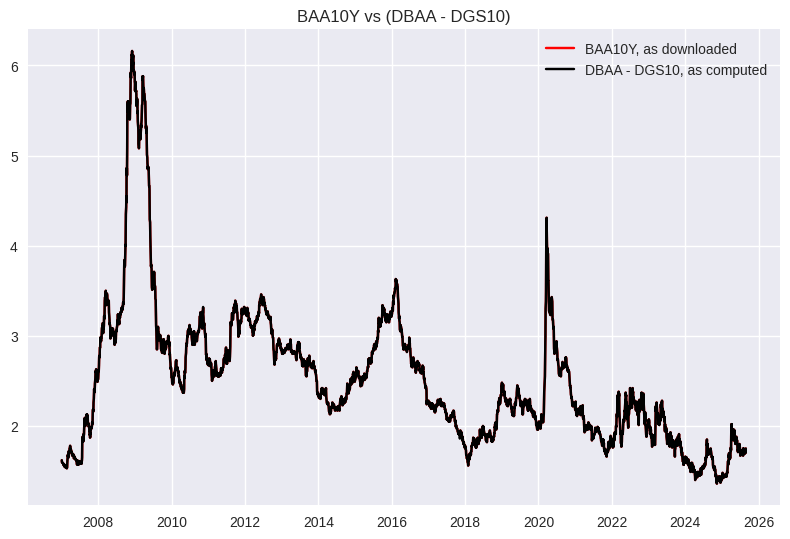

In [6]:
# check BAA10Y is exactly DBAA - DGS10
fig, ax = plt.subplots()
ax.plot(fred_data.index, fred_data["BAA10Y"], 'r', label="BAA10Y, as downloaded")
ax.plot(fred_data.index, fred_data["DBAA"] - fred_data["UST10"], 'k', label="DBAA - DGS10, as computed")
plt.title("BAA10Y vs (DBAA - DGS10)")
plt.legend()
plt.tight_layout()
plt.show()

For the sake of comparing the credit spread obtained from FRED data (`BAA10Y`) with the one obtained from market data (`LQD` - `^TNX`), we first adapt the former to have the same number of observations of the latter.

In [7]:
# Credit spread in decimal form
spread_fred = pd.Series(data=fred_data["BAA10Y"] / 100, index=sector_rets.index, name="Credit Spread from FRED") # from % to decimal per annum
spread_market = pd.Series(data=abs(rets["LQD"] - rets["^TNX"]), index=sector_rets.index, name="Credit Spread from markets").ffill()
print("shape of spread data from markets: ", spread_market.shape)

shape of spread data from markets:  (4686,)


In [8]:
print("shape of spread data from FRED: ", spread_fred.shape)

shape of spread data from FRED:  (4686,)


The credit spreads so obtained by two different sources are plotted in the figure below.

It is evident that the market measure (blue) is much more noisy than that obtained from FRED data (red).
We attribute this to the nature of `LQD` as a liquid (highly traded) instrument.
Its price is determined by supply and demand dynamics, rather than by the yields of the corporate bonds undergirding it.
In turn, this price will reflect the bonds' yields, but only indirectly through market participants' behaviour.

In support of the previous observation, we observe that the absolute value of the noisy market data seems to follow the same patterns as the more regular FRED data.
The two measures of credit spread seem to be correlated.

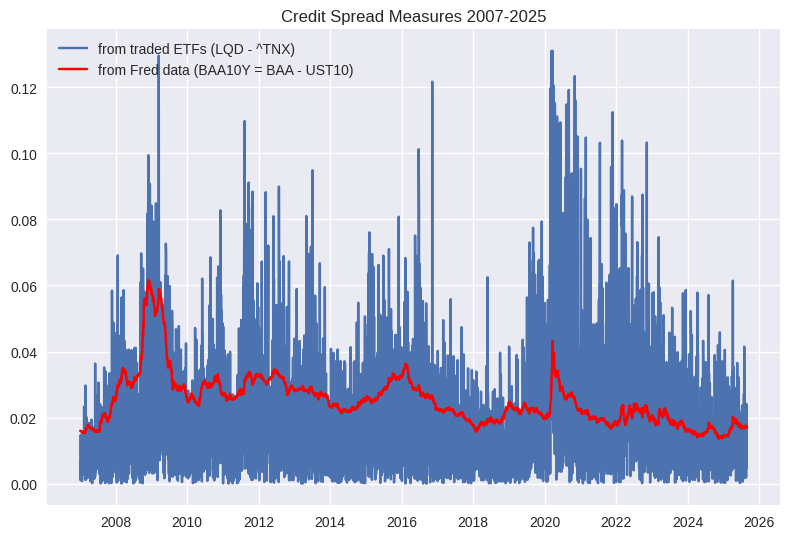

In [9]:
fig = plt.figure()
plt.plot(spread_market.index, spread_market, label="from traded ETFs (LQD - ^TNX)")
plt.plot(spread_fred.index, spread_fred, color='r', label="from Fred data (BAA10Y = BAA - UST10)")
plt.legend()
plt.title("Credit Spread Measures 2007-2025")
plt.tight_layout()
plt.show()

Now, in order to observe the correlations amongst the SPDR ETFs during the selected 2007-25 time window, we compute rolling correlation matrices for time windows of 60 trading days, advancing one day at the time.

The spectral decomposition (or PCA) of these rolling correlation matrices will yield the eigenvalues of the matrices.
The largest eigenvalue is found to represent the *market factor* that affects all securities, determining parallel shifts in stock prices.

Its *explained variance ratio* (EVR), i.e. the fraction of total portfolio variance it explains, grows in times of increased market uncertainty.
This consists in an undesirable increase in global correlation that could be exploited as a signal for a possibly incipient financial crisis.

In [10]:
def rolling_pca(returns, correlation_type, window=60):
    """
    correlation_type : str, choose among 'pearson', 'spearman' and 'kendall'
    returns : DataFrame (T x N) of zero-mean daily returns
    returns, evr        : DataFrame indexed by window end-date
    loadings_list       : list of Γ matrices (N x N) per window
    """

    evr_list, score_list, loadings_list = [], [], []
    idx = returns.index

    for t in range(window - 1, len(idx)):
        X = returns.iloc[t - window + 1 : t + 1]
        # C = np.corrcoef(X.T)                         # 11×11
        C = X.corr(method=correlation_type)
        vals, vecs = np.linalg.eigh(C)               # ascending

        # Sort descending and fix PC1 sign so XLK loading positive
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        if vecs[sector_tickers.index("XLK"), 0] < 0:
            vecs[:, 0] *= -1
        # Same procedure for PC2 & PC3 if desired (not necessary)

        evr_list.append(vals / vals.sum())
        loadings_list.append(vecs)
        score_list.append(vecs.T @ returns.iloc[t].values)

    dates = idx[window - 1 :]
    evr = pd.DataFrame(evr_list, index=dates,
                       columns=[f"EVR{k}" for k in range(1, len(returns.columns)+1)])
    scores = pd.DataFrame(score_list, index=dates,
                          columns=[f"PC{k}_score" for k in range(1, len(returns.columns)+1)])
    return evr, scores, loadings_list

We have updated the code in lesson $\S 4.3$ to compute the rolling correlation matrices to include not just computing the Pearson (linear) correlation, but also Spearman and Kendall correlations, to track nonlinear effects.

Below, we show the three correlation matrices for the 9 SPDR ETFs, not limited to a few days rolling window, but across the whole time period 2007-25:

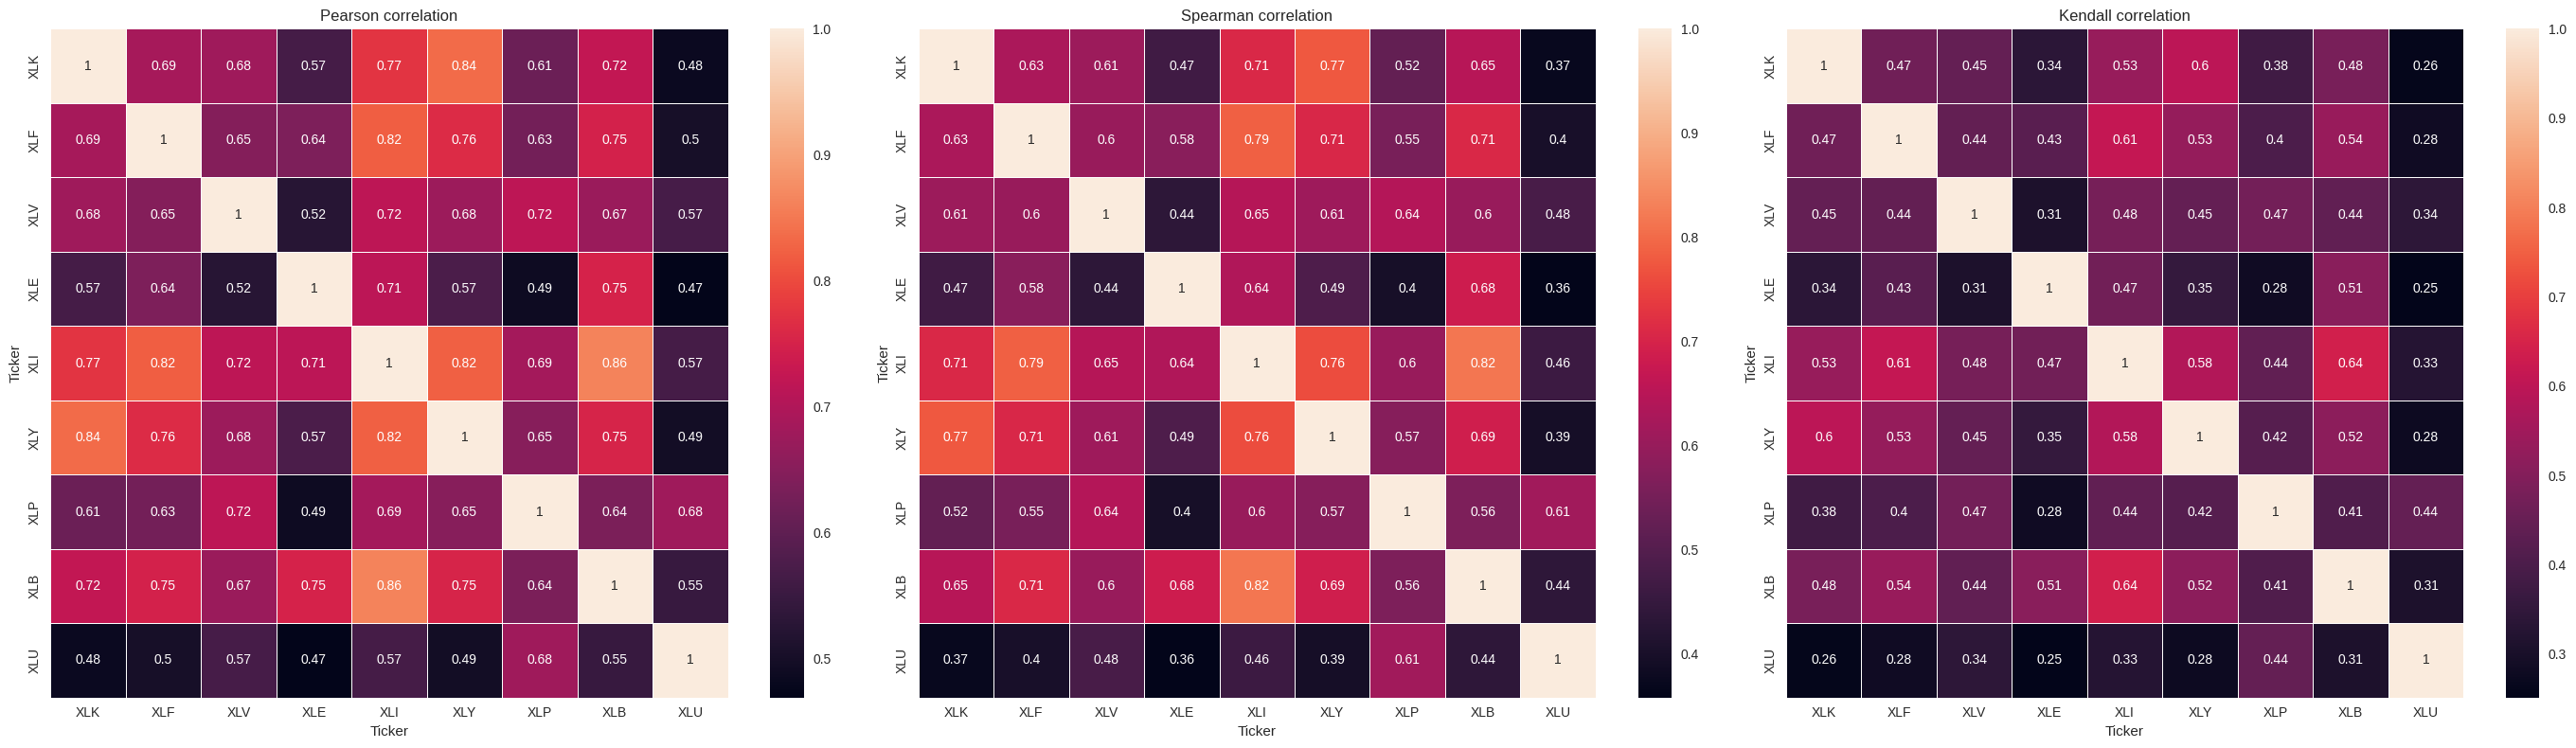

In [11]:
C_pearson = pd.DataFrame(np.corrcoef(sector_rets.T), index=sector_rets.columns, columns=sector_rets.columns)
# spearman correlation
C_spearman = sector_rets.corr(method='spearman')
# kendall correlation
C_kendall = sector_rets.corr(method='kendall')

fig, ax = plt.subplots(1, 3, squeeze=False, figsize=(28, 8))
ax1 = sns.heatmap(C_pearson, annot=True, linewidth=.5, ax=ax[0,0])
ax2 = sns.heatmap(C_spearman, annot=True, linewidth=.5, ax=ax[0,1])
ax3 = sns.heatmap(C_kendall, annot=True, linewidth=.5, ax=ax[0,2])
ax1.set(title="Pearson correlation")
ax2.set(title="Spearman correlation")
ax3.set(title="Kendall correlation")

plt.tight_layout()
plt.show()

We can see from the colorbars in the figures above, showing extreme values, that if nonlinear effects are included (Spearman and Kendall matrices), then the 9 ETFs are overall less correlated than the linear correlation matrix (Pearson) would imply.

Next, from the rolling 60-days correlations of returns, we compute the EVR for the first eigenvalue (EVR1).
We do it for each of the Pearson, Spearman and Kendall correlation matrices.

Notice how, on an average home workstation, the computational cost of obtaining the rolling Kendall correlations with Python is $20 \times$ more expensive than with the other methods.

| Correlation | Elapsed computation time ($s$) |
|:--|:--:|
| Pearson | 2.4 |
| Spearman | 3.9 |
| Kendall | 84.5 |

In [12]:
# Pearson EVR
evr_pearson, pcscores_pearson, _ = rolling_pca(sector_rets, 'pearson', window=60)

EVR1_pearson = evr_pearson["EVR1"]
PC2_z_pearson = (pcscores_pearson["PC2_score"]
         .rolling(120).apply(lambda x: (x.iloc[-1] - x.mean()) / x.std(),
                             raw=False))
PC3_score_pearson = pcscores_pearson["PC3_score"]

vix = prices["^VIX"].loc[EVR1_pearson.index]
tnx = prices["^TNX"].loc[EVR1_pearson.index] / 100        # ^TNX quote is yield×100

In [13]:
# Spearman EVR
evr_spearman, pcscores_spearman, _ = rolling_pca(sector_rets, 'spearman', window=60)

EVR1_spearman = evr_spearman["EVR1"]
PC2_z_spearman = (pcscores_spearman["PC2_score"]
         .rolling(120).apply(lambda x: (x.iloc[-1] - x.mean()) / x.std(),
                             raw=False))
PC3_score_spearman = pcscores_spearman["PC3_score"]

In [14]:
# Kendall EVR
evr_kendall, pcscores_kendall, _ = rolling_pca(sector_rets, 'kendall', window=60)

EVR1_kendall = evr_kendall["EVR1"]
PC2_z_kendall = (pcscores_kendall["PC2_score"]
         .rolling(120).apply(lambda x: (x.iloc[-1] - x.mean()) / x.std(),
                             raw=False))
PC3_score_kendall = pcscores_kendall["PC3_score"]

From plotting these EVR1s (blue) against time, and in comparison with the ^VIX index (gray), we observe that the EVR1 signal obtained from the Kendall correlation is much more conservative than the previous two.
It crosses the highest threshold of correlation (red dotted line) only in three occasions: 2010, 2011-12, and 2020.

It is noticeable that, contrary to the other two correlation methods, the Kendall correlation signal missed the 2007-08 Quant Crash and Great Financial Crisis.

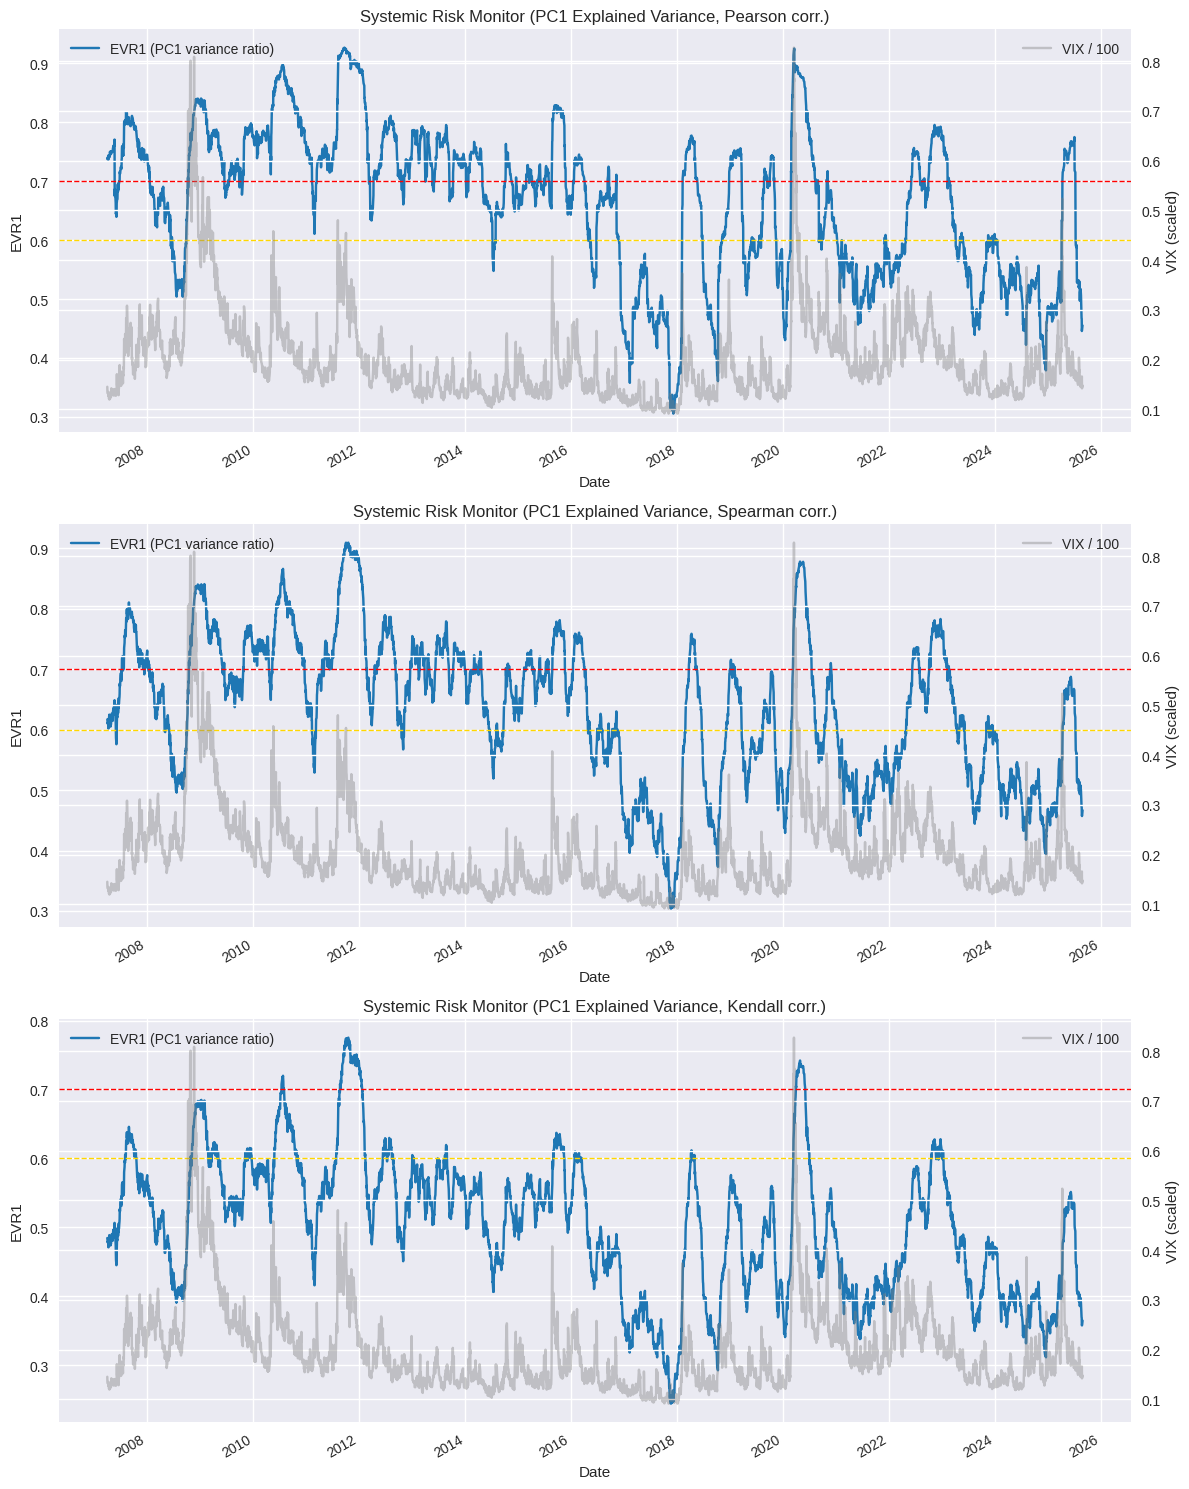

In [15]:
fig, ax1 = plt.subplots(3, 1, squeeze=False, figsize=(12,15))

# Pearson
EVR1_pearson.plot(ax=ax1[0,0], color="tab:blue", label="EVR1 (PC1 variance ratio)")
ax1[0,0].axhline(0.60, ls="--", color="gold", lw=1)
ax1[0,0].axhline(0.70, ls="--", color="red", lw=1)
ax1[0,0].set(ylabel="EVR1", title="Systemic Risk Monitor (PC1 Explained Variance, Pearson corr.)")
ax2_pearson = ax1[0,0].twinx()
(vix/100).plot(ax=ax2_pearson, color="tab:gray", alpha=0.4, label="VIX / 100")
ax2_pearson.set_ylabel("VIX (scaled)")
ax1[0,0].legend(loc="upper left"); ax2_pearson.legend(loc="upper right")

# Spearman
EVR1_spearman.plot(ax=ax1[1,0], color="tab:blue", label="EVR1 (PC1 variance ratio)")
ax1[1,0].axhline(0.60, ls="--", color="gold", lw=1)
ax1[1,0].axhline(0.70, ls="--", color="red", lw=1)
ax1[1,0].set(ylabel="EVR1", title="Systemic Risk Monitor (PC1 Explained Variance, Spearman corr.)")
ax2_spearman = ax1[1,0].twinx()
(vix/100).plot(ax=ax2_spearman, color="tab:gray", alpha=0.4, label="VIX / 100")
ax2_spearman.set_ylabel("VIX (scaled)")
ax1[1,0].legend(loc="upper left"); ax2_spearman.legend(loc="upper right")

# Kendall
EVR1_kendall.plot(ax=ax1[2,0], color="tab:blue", label="EVR1 (PC1 variance ratio)")
ax1[2,0].axhline(0.60, ls="--", color="gold", lw=1)
ax1[2,0].axhline(0.70, ls="--", color="red", lw=1)
ax1[2,0].set(ylabel="EVR1", title="Systemic Risk Monitor (PC1 Explained Variance, Kendall corr.)")
ax2_kendall = ax1[2,0].twinx()
(vix/100).plot(ax=ax2_kendall, color="tab:gray", alpha=0.4, label="VIX / 100")
ax2_kendall.set_ylabel("VIX (scaled)")
ax1[2,0].legend(loc="upper left"); ax2_kendall.legend(loc="upper right")

plt.tight_layout()
plt.show()

The next step of the analysis consists in checking whether credit spreads and our EVR1 signal are correlated.
It would be expected they are as credit spreads widen during systemic crises, just as the proportion of variance explained by the first eigenvalue (EVR1) grows larger.

We have two measures of credit spread, one coming from the FRED database and the other downloaded from the markets (LQD ticker as stand-in for corporate bonds), so we have to select the one better attuned to the EVR1 dataset.

For this purpose, we are going to proceed with a linear regression of the Pearson correlation EVR1 data with both the databases of credit spread at our disposal.

In [16]:
# linear regression PeaRSON EVR vs credit spreads,
Y = spread_market.loc["2007-04-02":]  # dependent variable (annual intensity)
X = evr_pearson[["EVR1", "EVR2", "EVR3"]]
X = sm.add_constant(X)   # intercept

ols = sm.OLS(Y, X).fit()
print(ols.summary())

                                OLS Regression Results                                
Dep. Variable:     Credit Spread from markets   R-squared:                       0.060
Model:                                    OLS   Adj. R-squared:                  0.060
Method:                         Least Squares   F-statistic:                     98.65
Date:                        Thu, 28 Aug 2025   Prob (F-statistic):           6.85e-62
Time:                                18:11:28   Log-Likelihood:                 12068.
No. Observations:                        4627   AIC:                        -2.413e+04
Df Residuals:                            4623   BIC:                        -2.410e+04
Df Model:                                   3                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

<AxesSubplot: xlabel='EVR1', ylabel='Credit Spread from markets'>

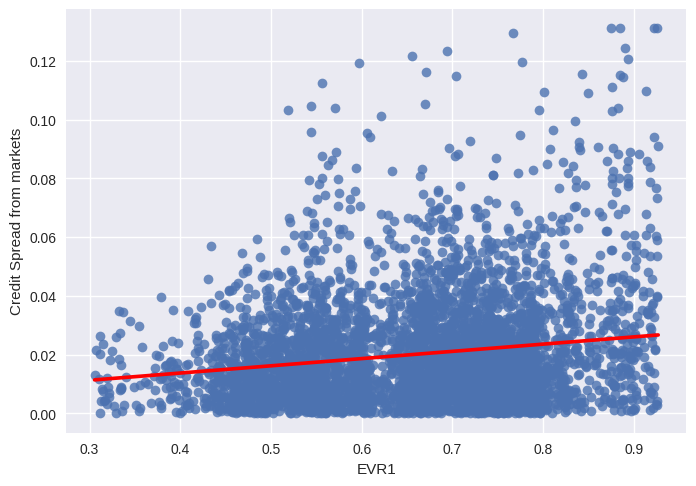

In [17]:
# plot regression
evr_pearson_spread_df = pd.concat([evr_pearson, spread_market], axis=1)
sns.regplot(x='EVR1', y='Credit Spread from markets', data=evr_pearson_spread_df, x_ci="ci", marker="o", scatter=True, line_kws=dict(color="r"), ci=None)

P-values $=0$ for the EVR1-2-3 coefficients in the regression are encouraging, however a low value for the $R^2$ statistic $=0.060$ on the contrary signals that a very low proportion of the total variance of the dependent variable, the credit spread, is explained by the EVR coefficients.

Therefore, we record a mixed outcome for this regression.

Next, much better results are obtained by regressing the EVR measure against the credit spread series from FRED:

In [18]:
# linear regression Pearson EVR vs Fred credit spreads
Y = spread_fred.loc["2007-04-02":].ffill()  # dependent variable (annual intensity)
X = evr_pearson[["EVR1", "EVR2", "EVR3"]]
X = sm.add_constant(X)   # intercept

ols_fred = sm.OLS(Y, X).fit()
print(ols_fred.summary())

                               OLS Regression Results                              
Dep. Variable:     Credit Spread from FRED   R-squared:                       0.296
Model:                                 OLS   Adj. R-squared:                  0.296
Method:                      Least Squares   F-statistic:                     648.3
Date:                     Thu, 28 Aug 2025   Prob (F-statistic):               0.00
Time:                             18:11:29   Log-Likelihood:                 16653.
No. Observations:                     4627   AIC:                        -3.330e+04
Df Residuals:                         4623   BIC:                        -3.327e+04
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

Text(0.5, 1.0, 'EVR1 from Spearman correlation vs Credit Spreads')

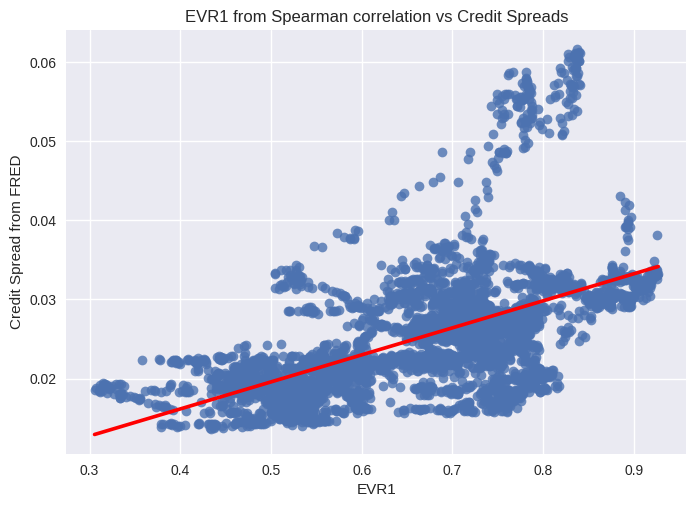

In [19]:
# plot regression
evr_pearson_spread_fred_df = pd.concat([evr_pearson, spread_fred], axis=1)
sns.regplot(x='EVR1', y='Credit Spread from FRED', data=evr_pearson_spread_fred_df, x_ci="ci", marker="o", scatter=True, line_kws=dict(color="r"), ci=None)
plt.title("EVR1 from Spearman correlation vs Credit Spreads")

Now the $R^2$ statistics is more solid, and at the same time the EVR1 coefficient estimation shows a solid p-stat score.

From this information we can infer that credit spreads from Fred are more dependable than their market counterpart, obtained from the LQD ETF.

Proceeding, we complete the picture with the next two regressions which will help selecting the most accurate correlation method for EVR1, in terms of how good it relates to the Fred credit spread.

In [20]:
# linear regression EVR (from Spearman corr) vs fred credit spreads
Y = spread_fred.loc["2007-04-02":].ffill()  # dependent variable (annual intensity)
X = evr_spearman[["EVR1", "EVR2", "EVR3"]]
X = sm.add_constant(X)   # intercept

ols_spearman = sm.OLS(Y, X).fit()
print(ols_spearman.summary())

                               OLS Regression Results                              
Dep. Variable:     Credit Spread from FRED   R-squared:                       0.347
Model:                                 OLS   Adj. R-squared:                  0.346
Method:                      Least Squares   F-statistic:                     817.6
Date:                     Thu, 28 Aug 2025   Prob (F-statistic):               0.00
Time:                             18:11:29   Log-Likelihood:                 16825.
No. Observations:                     4627   AIC:                        -3.364e+04
Df Residuals:                         4623   BIC:                        -3.362e+04
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

Text(0.5, 1.0, 'EVR1 from Spearman correlation vs Credit Spreads')

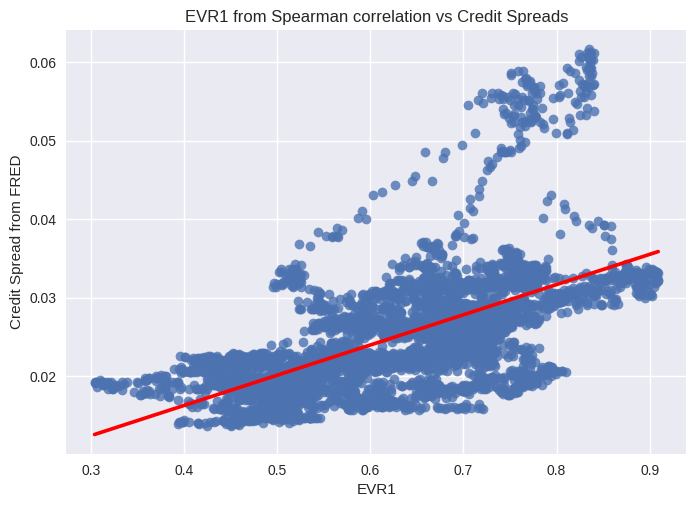

In [21]:
# plot regression
evr_spread_spearman_df = pd.concat([evr_spearman, spread_fred], axis=1)
sns.regplot(x='EVR1', y='Credit Spread from FRED', data=evr_spread_spearman_df, x_ci="ci", marker="o", scatter=True, line_kws=dict(color="r"), ci=None)
plt.title("EVR1 from Spearman correlation vs Credit Spreads")

In [22]:
# linear regression EVR (from Kendall corr) vs fred credit spreads
Y = spread_fred.loc["2007-04-02":].ffill()  # dependent variable (annual intensity)
X = evr_kendall[["EVR1", "EVR2", "EVR3"]]
X = sm.add_constant(X)   # intercept

ols_kendall = sm.OLS(Y, X).fit()
print(ols_kendall.summary())

                               OLS Regression Results                              
Dep. Variable:     Credit Spread from FRED   R-squared:                       0.349
Model:                                 OLS   Adj. R-squared:                  0.348
Method:                      Least Squares   F-statistic:                     825.5
Date:                     Thu, 28 Aug 2025   Prob (F-statistic):               0.00
Time:                             18:11:30   Log-Likelihood:                 16833.
No. Observations:                     4627   AIC:                        -3.366e+04
Df Residuals:                         4623   BIC:                        -3.363e+04
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

Text(0.5, 1.0, 'EVR1 from Kendall correlation vs Credit Spreads')

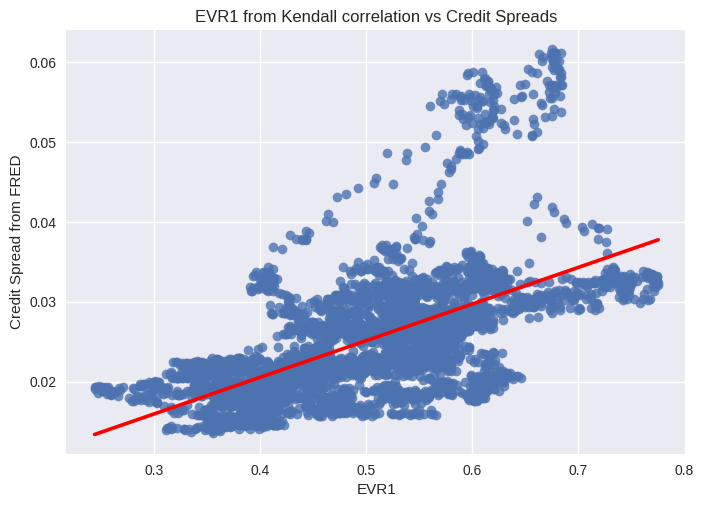

In [23]:
# plot regression
evr_spread_kendall_df = pd.concat([evr_kendall, spread_fred], axis=1)
sns.regplot(x='EVR1', y='Credit Spread from FRED', data=evr_spread_kendall_df, x_ci="ci", marker="o", scatter=True, line_kws=dict(color="r"), ci=None)
plt.title("EVR1 from Kendall correlation vs Credit Spreads")

All three correlation methods, Pearson, Spearman and Kendall, achieve a p-statistic $=0$ for the EVR1 coefficient.
Values of the $R^2$ statistic for Spearman and Kendall are better than Pearson's and more or less equal to each other. 
The standard error of the EVR1 coefficient in Spearman is slightly lower than Kendall's.

| Correlation | EVR1 coefficient | $R^2$ | EVR1 p-stat | EVR1 std err |
|:---|:---:|:---:|:---:|:---:|
| Pearson | 0.0364 | 0.296 | 0 | 0.003|
| Spearman | 0.0389 |  0.346 | 0 | 0.002|
| Kendall | 0.0481 | 0.349 | 0 | 0.003|

This, and additionally the previous observation that historical data for EVR1 from Kendall correlation is much more conservative and as such detects less false positives (good) due to noise, but also true positives (bad) such as the 2008 financial crisis, leads us to choose the Spearman correlation as our methodology to extract the EVR1 signal.

#### Generate a Systemic Risk Indicator (SRI) from correlation breakdown and widening credit spreads

An obvious observation that can be made of the above procedure that led us to pick the Spearman correlation matrix to generate the EVR1 metric, is that we applied linear regressions over a correlation measure that tracks nonlinearities.

The analysis would greatly benefit from employing Machine Learning in stead of linear regression to track these nonlinearities, at the price of course of more obfuscation in the selection process.

Indeed, the (Spearman EVR1 - credit spread) linear regression coefficient of 0.0389 is quite feeble, but this also might help justifying the construction of a SRI as linear combination of EVR1 and credit spread.
The two terms are expected to correlate more heavily during crises, while a linear combination-based SRI would instead suggest EVR1 and credit spread to be independent from each other.
However, a weak correlation when markets are placid might make an acceptable proxy for independence, while the linear combination will still cause the SRI to increase at market phase shifts, just more so than if the rising (EVR1-credit spreads) correlation were to be taken into account.

Therefore, we could define the SRI as following

$$\text{SRI}(\text{credit spread}, \text{EVR1}) = \alpha \cdot \text{credit spread} + \beta \cdot \text{EVR1}$$

where coefficients $\alpha , \, \beta$ could be selected from a Least Squares minimisation procedure.

The sum of squared residuals $\Delta$ to minimise might be the distance of the SRI from the ^VIX index, as volatility increases during crises, and our goal is to generate an indicator of crises.

$$\Delta = \sum_i \lVert \text{SRI}_i - \text{VIX}_i \rVert^2 $$

For each observation $i \in [2007, 2025]$ inside the selected timeframe.

In [24]:
from scipy.optimize import least_squares, curve_fit

In [25]:
def SRI(input, alpha, beta):
  spread = input.iloc[:,0].to_numpy()
  EVR1 = input.iloc[:,1].to_numpy()
  
  return alpha * spread + beta * EVR1

In [26]:
aggregated_data = pd.concat([spread_fred.loc["2007-04-02":], EVR1_spearman], axis=1)

popt, pcov, infodict, mesg, ier = curve_fit(SRI, aggregated_data, vix/100, bounds=(0., 10.), full_output=True)
popt

array([6.2757966 , 0.06632807])

In [27]:
# debug
pcov

array([[ 2.39757937e-02, -9.54392879e-04],
       [-9.54392879e-04,  4.03651852e-05]])

In [28]:
# debug
infodict

{'nfev': 13,
 'fvec': array([ 0.00481102,  0.01475095,  0.01725737, ..., -0.00331765,
        -0.01036161, -0.00543225])}

In [29]:
# debug
mesg

'`gtol` termination condition is satisfied.'

In [30]:
# debug
ier

1

In [31]:
# stddev of coefficients
perr = np.sqrt(np.diag(pcov))
perr

array([0.15484119, 0.00635336])

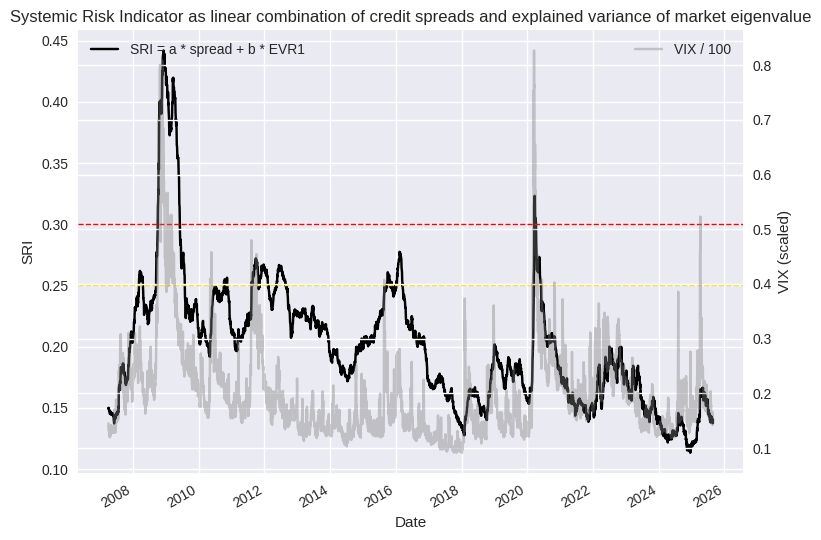

In [32]:
# SRI
popt_tot = np.sum(popt)
alpha = popt[0] #/ popt_tot
beta = popt[1] #/ popt_tot
SRI = alpha * spread_fred + beta * EVR1_spearman

fig, ax1 = plt.subplots()

SRI.plot(ax=ax1, color="k", label="SRI = a * spread + b * EVR1")
ax1.axhline(0.25, ls="--", color="gold", lw=1)
ax1.axhline(0.3, ls="--", color="red", lw=1)
ax1.set(ylabel="SRI", title="Systemic Risk Indicator as linear combination of credit spreads and explained variance of market eigenvalue")
ax2 = ax1.twinx()
(vix/100).plot(ax=ax2, color="tab:gray", alpha=0.4, label="VIX / 100")
ax2.set_ylabel("VIX (scaled)")
ax1.legend(loc="upper left"); ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

#### Student C: extension of a DCC-GARCH framework with funding stress indicators acting as regime change detectors


Dynamical Conditional Correlation generalized autoregressive conditional heteroskedasticity (DCC-GARCH) is a model capable of estimating large time-varying covariance matrices. It does this by using estimating volatilities individually for each asset using GARCH for each separate time series.

The DCC (Dynamic Conditional Correlation) component is what makes the model "integrated" and powerful. It models how the correlations between these assets change over time. In a stable market, the correlation between stocks and bonds might be low or even negative. But during a market crisis, the correlation between almost all assets tends to spike towards 1 which is usually called a correlation spike.

In our case we will model use market sector tracker ETFs and market stress indicators as data for our correlation modeling, the idea is to be able to infer when the probability of correlation spikes are higher ahead of time. The data we are using are:

#### Sector tracking ETFs:
- XLY: Consumer Discretionary
- XLP: Consumer Staples
- XLE: Energy
- XLF: Financials
- XLV: Health Care
- XLI: Industrials
- XLB: Materials
- XLK: Technology
- XLU: Utilities

#### Market stress indicators [1](https://fred.stlouisfed.org/)

- TED: Treasury-Eurodollar spread (This one has been discontinued by FRED in favour of Secured Overnight Financing Rate (SOFR) )
- SOFR: Secured Overnight Financing Rate
- DFF: Federal Funds Effective Rate
- NFCI: Chicago Fed National Financial Conditions Index
- STLFSI4: St. Louis Fed Financial Stress Index
- VIX:CBOE Volatility Index


The difference between SOFR and DFF can be taken as a proxy of cross currency basis since it indicates dollar liquidity in the repo market. Adding these market indicators, builds on top of the materials provided by WQU.

In [33]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import yfinance as yf
from arch import arch_model
from fredapi import Fred

plt.rcParams["figure.figsize"] = (10,4)
fred = Fred(api_key='6caf186362e54dbfc3d2be7972c1e3df')
tickers_yahoo = ['XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU',"^VIX"]
tikers_stress= ['TEDRATE', 'SOFR', 'DFF', 'NFCI', 'STLFSI4']
tickers = tickers_yahoo + tikers_stress
tickers=tickers+['SOFR_FFS_Spread']

## Function to download the data based on the starting and end dates
def data_for_dcc(start='2018-01-01', end='2023-12-31'):
  prices  = yf.download(tickers_yahoo, start=start, end=end,progress=False)['Close']
  # TED SPREAD Data
  ted_spread = fred.get_series('TEDRATE',observation_start=start,observation_end=end)
  # Get the SOFR and Federal Funds Rate data (Their difference will be a cross currency basis proxy)
  sofr = fred.get_series('SOFR',observation_start=start,observation_end=end)
  fed_funds_rate = fred.get_series('DFF',observation_start=start,observation_end=end)
  nfci_rate = fred.get_series('NFCI',observation_start=start,observation_end=end)
  stlfsi4_rate = fred.get_series('STLFSI4',observation_start=start,observation_end=end)
  # Combine the series into a single DataFrame
  rates = pd.concat([ted_spread,sofr, fed_funds_rate,nfci_rate,stlfsi4_rate], axis=1)
  rates.columns = ['TEDRATE','SOFR', 'DFF','NFCI','STLFSI4']
  # Calculate the SOFR-FFS spread
  rates['SOFR_FFS_Spread'] = rates['SOFR'] - rates['DFF']
  # returns
  factor_rets    = 100 * prices.interpolate(method='linear', axis=0).pct_change()
  rate_rets =  rates.interpolate(method='linear', axis=0)
  rets = pd.concat([factor_rets, rate_rets], axis=1).dropna()
  return rets
rets=data_for_dcc()

After obtaining the data we run a $GARCH(1,1)$ model with a Gaussian error term. then  we standardise the residuals,and collect the results in a dataframe.


In [34]:
# Fit GARCH(1,1) to each series and collect standardized residuals
std_resid = pd.DataFrame(index=rets.index, columns=rets.columns)
for tkr in tickers :
    fit = arch_model(rets[tkr], vol='GARCH', p=1, q=1).fit(disp="off")
    std_resid[tkr] = fit.resid / fit.conditional_volatility

In [35]:
# Simple DCC(1,1) log‑likelihood and parameter search
def dcc_loglik(params, eps):
    a, b = params                       # 1  unpack $\alpha$ and $\beta$ (the only DCC params)
    if a <= 0 or b <= 0 or a + b >= 1:  # 2  coarse stationarity/positivity check
        return np.inf                   #    infeasible → infinite loss

    T, N        = eps.shape             # 3  sample length T and #assets N
    Qbar        = eps.cov().values      # 4  unconditional correlation of shocks
    Q_prev      = Qbar.copy()           # 5  initialise recursion at Qbar
    loglike     = 0.0                   # 6  accumulator for (−2)·log‑likelihood

    for t in range(1, T):               # 7  walk through time
        e_prev = eps.iloc[t-1].values[:, None]         # 8  $\epsilon_{t‑1}$ column‑vector
        Q_t    = (1-a-b)*Qbar + a*e_prev@e_prev.T + b*Q_prev   # 9  DCC recursion

        d      = np.sqrt(np.diag(Q_t))  # 10 diagonal of $Q_t$ → std‑dev vector
        R_t    = Q_t / d[:,None] / d[None,:]           # 11 convert $Q_t$ → correlation
        Q_prev = Q_t                    # 12 roll $Q_t$ forward

        loglike += np.log(np.linalg.det(R_t)) + \
                   eps.iloc[t] @ np.linalg.inv(R_t) @ eps.iloc[t]   # 13 contrib.

    return 0.5*loglike                  # 14 QMLE objective (minimiser wants small)


from scipy.optimize import minimize
opt = minimize(dcc_loglik, x0=[0.05, 0.90],
               args=(std_resid,), bounds=[(1e-3,0.99)]*2)

a_dcc, b_dcc = opt.x
print(f"DCC alpha={a_dcc:.3f},  beta={b_dcc:.3f},  persistence={a_dcc+b_dcc:.3f}")

DCC alpha=0.050,  beta=0.900,  persistence=0.950


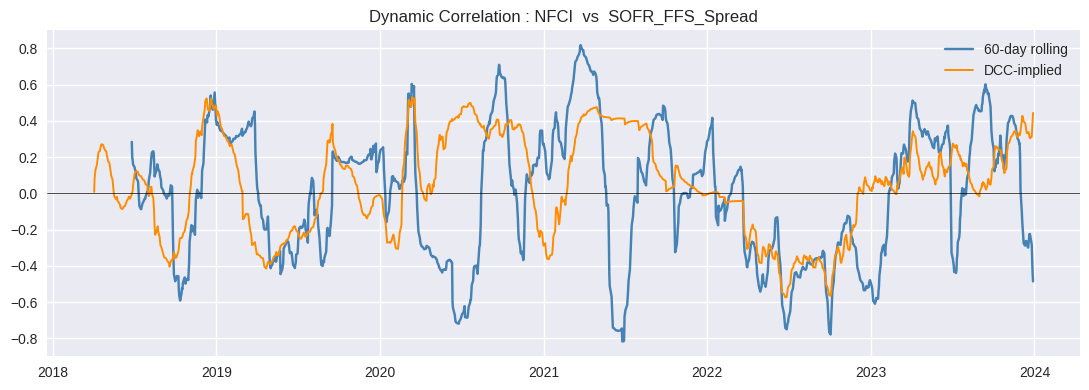

In [36]:
# 1. Reconstruct the entire DCC correlation series for a chosen pair
def dcc_corr_series(eps, a, b, i, j):
    """Return a pd.Series with the DCC-implied correlation ρ_{ij,t}."""
    T      = len(eps)
    Q_bar  = eps.cov().values
    Q_prev = Q_bar.copy()
    rho    = np.empty(T)

    for t in range(T):
        if t > 0:
            e_prev = eps.iloc[t-1].values[:, None]
            Q_t    = (1-a-b)*Q_bar + a*e_prev@e_prev.T + b*Q_prev
        else:
            Q_t = Q_prev                       # at t=0 use Q̄

        d = np.sqrt(np.diag(Q_t))
        R_t = Q_t / d[:,None] / d[None,:]
        rho[t] = R_t[i, j]
        Q_prev = Q_t                           # roll forward

    return pd.Series(rho, index=eps.index)

pair   = ('NFCI', 'SOFR_FFS_Spread')
i, j   = tickers.index(pair[0]), tickers.index(pair[1])
dcc_r  = dcc_corr_series(std_resid, a_dcc, b_dcc, i, j)
roll_r = rets[pair[0]].rolling(60).corr(rets[pair[1]])

# 2. One clear plot: model vs naïve rolling estimate
plt.figure(figsize=(11,4))
plt.plot(roll_r,  label='60-day rolling',  color='steelblue')
plt.plot(dcc_r,   label='DCC-implied',     color='darkorange', linewidth=1.4)
plt.title(f"Dynamic Correlation : {pair[0]}  vs  {pair[1]}")
plt.axhline(0, color='k', lw=.5); plt.legend(); plt.tight_layout()
plt.show()


A cascade effect in financial markets describes a chain reaction where a shock to one part of the system rapidly spreads to others, creating a self-reinforcing loop of instability. This process often begins with a volatility shock—a sudden, sharp increase in market uncertainty, often triggered by an unexpected event.

A good proxy for this is the VIX which is a measure of the expected volatility of the market as a whole, when it is big the markets are quite volatile which usually means it is moving as a whole and correlations are close to one. We observe our DCC indicator (which measures the correlation between NFCI and our cross currency proxy) seems to be able to predict ahead of time when spikes in the vix will be present, we see that from 2023 the indicator breaks down, this is most likely due to the Fed changing its economic policies and entering into a high interest rate regime which had not been seen in many years [3](https://www.congress.gov/crs-product/IN12388#:~:text=The%20Federal%20Reserve%20(Fed)%20responded,the%20highest%20target%20since%202001.), other correlation pairs were considered but this is the one we found gave the best predictions for low interest rates environments.


Text(0.5, 1.0, 'Dynamic Correlation vs. VIX Index')

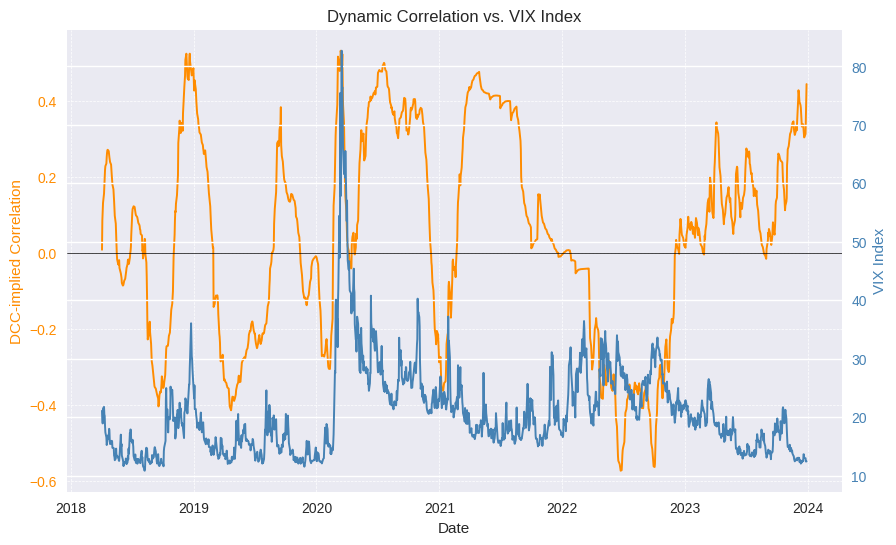

In [37]:
vix_clipped = vix.loc[rets.index[0]:rets.index[-1]] # yf.download("^VIX", start=rets.index[0], end=rets.index[-1],progress=False)['Close']
# Create a single plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot DCC on the first y-axis
color = 'darkorange'
ax1.set_xlabel('Date')
ax1.set_ylabel('DCC-implied Correlation', color=color)
ax1.plot(dcc_r.index, dcc_r, label='DCC-implied Correlation', color=color, linewidth=1.4)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(0, color='k', lw=.5)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Create a second y-axis for VIX
ax2 = ax1.twinx()
color = 'steelblue'
ax2.set_ylabel('VIX Index', color=color)
ax2.plot(vix_clipped.index, vix_clipped, label='VIX Index', color=color, linewidth=1.4)
ax2.tick_params(axis='y', labelcolor=color)

# Add a single title for the plot
plt.title('Dynamic Correlation vs. VIX Index')


This shock immediately leads to a correlation spike, as a sudden "risk-off" sentiment causes investors to sell all assets indiscriminately, driving their prices down in unison. Assets that were once uncorrelated or negatively correlated now move together, eliminating the benefits of diversification.

The increased volatility and correlation then trigger a funding freeze. As lenders become hesitant to extend credit due to heightened risk, market liquidity dries up. This forces institutions to sell assets to meet their funding needs, which in turn drives prices down further, causing even more volatility. This completes the feedback loop, as the funding freeze exacerbates the initial volatility shock. This cascade demonstrates how seemingly distinct market dynamics are deeply interconnected, creating a vicious cycle that can lead to a systemic crisis.


## Global Systemic Risk Indicator

In [38]:
start_date = "2018-04-03"
end_date = "2023-12-31"

# gather data
student_a_indicator = SRI.loc[start_date:end_date]
student_b_indicator = pd.Series(data = np.zeros(student_a_indicator.shape), index=student_a_indicator.index) # all zeroes for now
student_c_indicator = dcc_r

In [39]:
# find coefficients of this global indicator linear function
def global_SRI(input, alpha, beta, gamma):
  student_a = input.iloc[:,0].to_numpy()
  student_b = input.iloc[:,1].to_numpy()
  student_c = input.iloc[:,2].to_numpy()
  
  return alpha * student_a + beta * student_b + gamma * student_c

In [40]:
aggregated_data_all_students = pd.concat([student_a_indicator, student_b_indicator, student_c_indicator], axis=1)

# calibrate function
popt_global, pcov_global, infodict_global, mesg_global, ier_global = curve_fit(global_SRI, aggregated_data_all_students, vix_clipped/100, bounds=(0., 10.), full_output=True)
popt_global # alpha, beta, gamma

array([1.20491035e+00, 9.08690298e+00, 4.94748507e-03])

In [41]:
# debug
pcov_global

array([[ 8.34700383e-05,  0.00000000e+00, -1.08880584e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.08880584e-05,  0.00000000e+00,  3.46999123e-05]])

In [42]:
# debug
infodict_global

{'nfev': 25,
 'fvec': array([-0.01250069, -0.00096198,  0.00967762, ...,  0.04886526,
         0.04708375,  0.04717704])}

In [43]:
# debug
mesg_global

'`ftol` termination condition is satisfied.'

In [44]:
# debug
ier_global

2

In [45]:
# stddev of our coefficients "popt_global"
perr_global = np.sqrt(np.diag(pcov_global))
perr_global

array([0.00913619, 0.        , 0.00589066])

In [46]:
# Global SRI
popt_tot_global = np.sum(popt_global) # useless
alpha_global = popt_global[0]
beta_global = popt_global[1] 
gamma_global = popt_global[2]

signal_indicator = alpha_global * student_a_indicator + beta_global * student_b_indicator + gamma_global * student_c_indicator

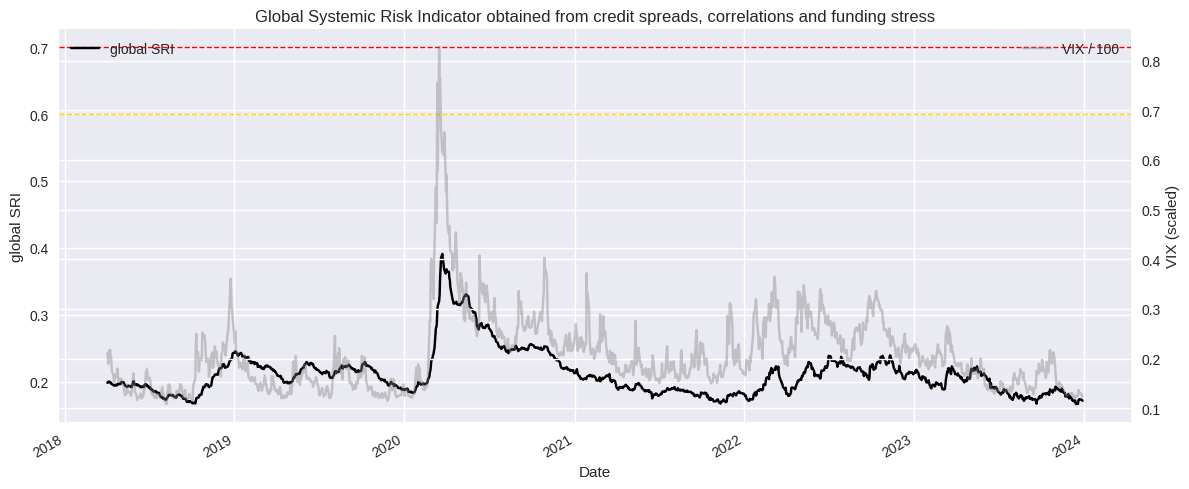

In [47]:
# plot signal indicator against vix
fig, ax1 = plt.subplots(figsize=(12,5))

signal_indicator.plot(ax=ax1, color="k", label="global SRI")
ax1.axhline(0.60, ls="--", color="gold", lw=1)
ax1.axhline(0.70, ls="--", color="red", lw=1)
ax1.set(ylabel="global SRI", title="Global Systemic Risk Indicator obtained from credit spreads, correlations and funding stress")
ax2 = ax1.twinx()
(vix_clipped/100).plot(ax=ax2, color="tab:gray", alpha=0.4, label="VIX / 100")
ax2.set_ylabel("VIX (scaled)")
ax1.legend(loc="upper left"); ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

### References

- FRED database, **https://fred.stlouisfed.org/series**, accessed on 25 August 2025